<a href="https://colab.research.google.com/github/coyolxahuqui/Tareas-UIC/blob/main/Modelo_de_traducci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib

In [ ]:
import keras
from keras import layers
from keras.layers import TextVectorization

In [ ]:
import pathlib
import random
import string
import re
import numpy as np

In [ ]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Funciones para cargar y preparar los datos
def load_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.read().strip().split('\n')
    return [line.split('\t')[:2] for line in lines]

# Ruta al archivo de datos

data = load_data(text_file)

# Dividir los datos en inglés y español
input_texts = [text[0] for text in data]
target_texts = ['\t' + text[1] + '\n' for text in data]  # Añadir tokens de inicio y fin a las frases objetivo

# Tokenizar y convertir a secuencias
input_tokenizer = Tokenizer(num_words=10000)
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

target_tokenizer = Tokenizer(num_words=10000, filters='')
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

# Rellenar secuencias
max_input_len = max(len(seq) for seq in input_sequences)
max_target_len = max(len(seq) for seq in target_sequences)

encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len)
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, 0:-1] = decoder_input_data[:, 1:]


In [ ]:
# Dimensiones del modelo
embedding_size = 256
lstm_units = 256

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=10000, output_dim=embedding_size)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=10000, output_dim=embedding_size)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Atención
attention = Attention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenar la salida de la atención con los outputs del decoder
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_output])

# Capa densa para la predicción
decoder_dense = Dense(10000, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Definir el modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            2560000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            2560000   ['input_2[0][0]']             
                                                                                              

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
                    batch_size=64,
                    epochs=30,
                    validation_split=0.2)


Epoch 1/30
1488/1488 [==============================] - 101s 64ms/step - loss: 0.6396 - accuracy: 0.9157 - val_loss: 1.2715 - val_accuracy: 0.8252
Epoch 2/30
1488/1488 [==============================] - 102s 69ms/step - loss: 0.5734 - accuracy: 0.9168 - val_loss: 1.2065 - val_accuracy: 0.8277
Epoch 3/30
1488/1488 [==============================] - 102s 68ms/step - loss: 0.5461 - accuracy: 0.9198 - val_loss: 1.1382 - val_accuracy: 0.8347
Epoch 4/30
1488/1488 [==============================] - 102s 69ms/step - loss: 0.5174 - accuracy: 0.9228 - val_loss: 1.1051 - val_accuracy: 0.8362
Epoch 5/30
1488/1488 [==============================] - 102s 68ms/step - loss: 0.4879 - accuracy: 0.9261 - val_loss: 1.0750 - val_accuracy: 0.8395
Epoch 6/30
1488/1488 [==============================] - 102s 68ms/step - loss: 0.4604 - accuracy: 0.9290 - val_loss: 1.0140 - val_accuracy: 0.8479
Epoch 7/30
1488/1488 [==============================] - 93s 62ms/step - loss: 0.4364 - accuracy: 0.9318 - val_loss: 0.

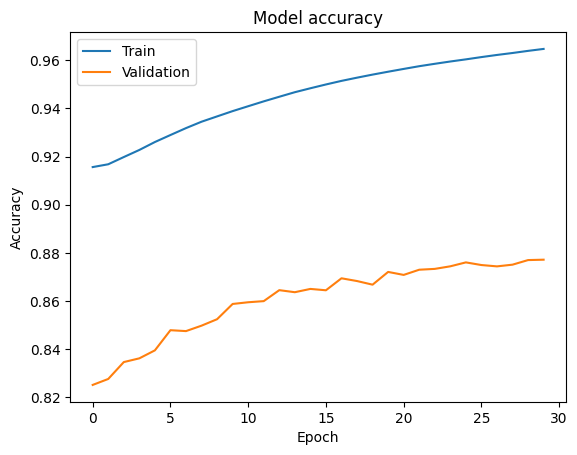

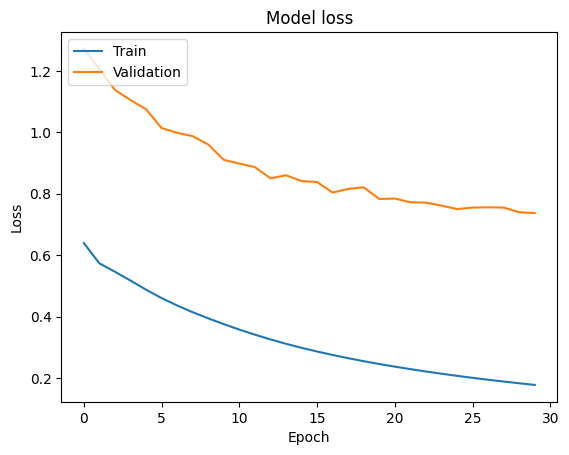

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
print(target_tokenizer.word_index)

{'de': 1, 'que': 2, 'a': 3, 'la': 4, '\ttom': 5, 'en': 6, 'el': 7, 'no': 8, 'es': 9, 'un': 10, '\tno': 11, 'se': 12, 'una': 13, 'lo': 14, 'por': 15, '\tél': 16, 'me': 17, 'con': 18, 'está': 19, 'su': 20, '\tel': 21, 'para': 22, 'los': 23, 'y': 24, 'le': 25, '\tella': 26, 'mi': 27, 'tom': 28, '\tme': 29, 'al': 30, 'las': 31, 'más': 32, '\tla': 33, 'te': 34, 'qué': 35, 'muy': 36, 'tu': 37, 'del': 38, 'mary': 39, 'tiene': 40, 'tom.\n': 41, 'estaba': 42, '\tyo': 43, 'como': 44, '\t¿qué': 45, 'fue': 46, '\tes': 47, 'mary.\n': 48, 'esta': 49, 'él': 50, '\testoy': 51, '\tmi': 52, 'gusta': 53, 'hacer': 54, 'ha': 55, 'tan': 56, 'este': 57, '\ta': 58, 'son': 59, 'si': 60, '\tlos': 61, 'puedo': 62, 'era': 63, 'ser': 64, 'algo': 65, '\t¿por': 66, 'ir': 67, 'mucho': 68, '\ttengo': 69, 'puede': 70, 'todo': 71, '\tquiero': 72, 'quiero': 73, 'dos': 74, 'cuando': 75, 'sus': 76, 'pero': 77, '\tse': 78, '\tlo': 79, 'tengo': 80, 'estoy': 81, 'dijo': 82, 'casa': 83, '\tellos': 84, '\tte': 85, 'vez': 86, '\

In [ ]:
# Definir el modelo del encoder para la inferencia
encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

# Definir el modelo del decoder para la inferencia
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_encoder_outputs_input = Input(shape=(max_input_len, lstm_units))
attention_output_inf = attention([decoder_outputs, decoder_encoder_outputs_input])
decoder_concat_input_inf = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_output_inf])

decoder_outputs = decoder_dense(decoder_concat_input_inf)
decoder_model = Model([decoder_inputs, decoder_encoder_outputs_input] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Función para realizar la traducción
def translate(input_text):
    # Tokenizar y padear el texto de entrada
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len)

    # Obtener el estado del encoder
    enc_outs, enc_last_state_h, enc_last_state_c = encoder_model.predict(input_seq)

    # Generar secuencia de salida vacía
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_tokenizer.word_index['\t']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, enc_outs, enc_last_state_h, enc_last_state_c])

        # Muestrear un token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_tokenizer.index_word[sampled_token_index]
        decoded_sentence += sampled_char

        # Salir si se alcanza la longitud máxima o se encuentra el token de 'fin'
        if (sampled_char == '\n' or len(decoded_sentence) > max_target_len):
            stop_condition = True

        # Actualizar la secuencia de entrada del decoder (token por token)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar estados
        enc_last_state_h, enc_last_state_c = h, c

    return decoded_sentence

# Ejemplo de uso
input_sentence = "Hello, how are you?"
translated_sentence = translate(input_sentence)
print("English:", input_sentence)
print("Spanish:", translated_sentence)


1/1 [==============================] - 1s 877ms/step


KeyError: '\t'